In [1]:
import numpy as np
import librosa
import os
import re
import pandas as pd

loaded file 00000995-100507_segmented.npy


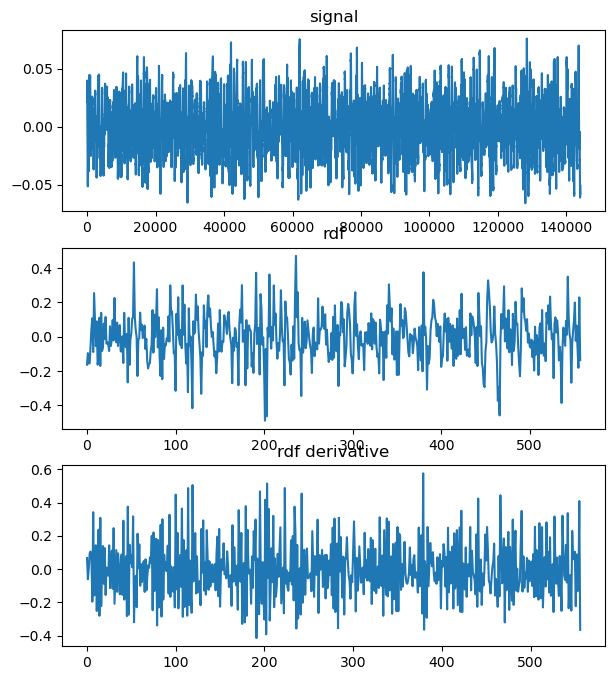

In [2]:

def frame_signal(x, frame_length, hop_length):
    """
    Frame a 1-D array x into overlapping frames.
    Returns an array shape (n_frames, frame_length).
    """
    x = np.asarray(x, dtype=float)
    if x.ndim != 1:
        raise ValueError("Input must be 1-D")
    if frame_length <= 0 or hop_length <= 0:
        raise ValueError("frame_length and hop_length must be > 0")
    if len(x) < frame_length:
        # pad with zeros so we get one frame
        pad = frame_length - len(x)
        x = np.concatenate([x, np.zeros(pad, dtype=x.dtype)])

    n_frames = 1 + (len(x) - frame_length) // hop_length
    if n_frames <= 0:
        n_frames = 1
    shape = (n_frames, frame_length)
    strides = (x.strides[0] * hop_length, x.strides[0])
    try:
        frames = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
    except Exception:
        # fallback: explicit framing
        frames = np.stack([x[i*hop_length : i*hop_length + frame_length] for i in range(n_frames)])
    return frames.copy()  # copy for safety


def frame_rms(x, frame_length=2048, hop_length=512, eps=1e-12):
    """
    Compute RMS for each frame.
    Returns rms: array of length n_frames
    """
    frames = frame_signal(x, frame_length, hop_length)
    # mean square then sqrt
    ms = np.mean(frames**2, axis=1)
    rms = np.sqrt(np.maximum(ms, 0.0))
    # avoid exact zeros for later log operations
    rms = np.maximum(rms, eps)
    return rms


def rdf_log_ratio(rms, eps=1e-12):
    """
    Recommended RDF: derivative of log RMS (i.e., log(RMS[t]) - log(RMS[t-1])).
    Returns array of length len(rms)-1.
    This equals np.diff(np.log(rms)), numerically stable if rms > 0.
    """
    rms = np.asarray(rms, dtype=float)
    return np.diff(np.log(rms + eps))


# def rdf_log_of_derivative(rms, eps=1e-12, preserve_sign=True):
#     """
#     Alternative: take derivative (difference) of RMS, then take log of its magnitude.
#     Returns array of length len(rms)-1.

#     If preserve_sign is True, returns sign(diff_rms) * log(|diff_rms| + eps)
#     so sign of increase/decrease is preserved but magnitude is log-scaled.
#     If preserve_sign is False, returns log(|diff_rms| + eps).
#     """
#     d = np.diff(rms)
#     if preserve_sign:
#         return np.sign(d) * np.log(np.abs(d) + eps)
#     else:
#         return np.log(np.abs(d) + eps)


def derivative_of_rdf(rdf, dt=1.0):
    """
    Time derivative of the RDF array.
    rdf: 1-D array (e.g., output of rdf_log_ratio or rdf_log_of_derivative)
    dt: time between rdf samples (in seconds or in frame steps). Default 1.0 means per-frame step.
    Returns array of length len(rdf)-1 (i.e., second differences).
    """
    rdf = np.asarray(rdf, dtype=float)
    return np.diff(rdf) / dt


# convenience combined function that takes raw audio and returns:
# - frame_times (frame center time indices in frames)
# - rms
# - rdf (recommended)
# - rdf_derivative
def compute_rdf_from_audio(x, sr=44100, frame_length=2048, hop_length=512, method='ratio'):
    """
    Compute RMS, RDF and derivative-of-RDF from a 1-D audio signal.

    Parameters
    ----------
    x : 1-D array
        audio samples
    sr : int
        sample rate (Hz); used to compute time axis
    frame_length : int
    hop_length : int
    method : 'ratio' or 'log-derivative'
        'ratio'      -> rdf = diff(log(RMS))  (recommended)
        'log-derivative' -> rdf = sign(diff(RMS)) * log(|diff(RMS)| + eps)

    Returns
    -------
    dict with keys:
      'times' : array of frame center times in seconds (length n_frames)
      'rms' : RMS per frame (length n_frames)
      'rdf' : RDF array (length n_frames-1)
      'rdf_times' : times aligned to rdf (length n_frames-1) -- centered between frames
      'rdf_derivative' : derivative of rdf (length n_frames-2)
      'rdf_derivative_times' : times aligned to rdf_derivative
    """
    x = np.asarray(x, dtype=float)
    rms = frame_rms(x, frame_length=frame_length, hop_length=hop_length)
    n_frames = len(rms)
    # frame center times (approx)
    frame_centers = (np.arange(n_frames) * hop_length + frame_length / 2.0) / float(sr)

    if method == 'ratio':
        rdf = rdf_log_ratio(rms)
    elif method == 'log-derivative':
        rdf = rdf_log_of_derivative(rms, preserve_sign=True)
    else:
        raise ValueError("method must be 'ratio' or 'log-derivative'")

    rdf_times = (frame_centers[:-1] + frame_centers[1:]) / 2.0
    # derivative of rdf (second difference)
    rdf_deriv = derivative_of_rdf(rdf, dt=1.0)  # dt in frames; convert to seconds if wanted
    rdf_deriv_times = (rdf_times[:-1] + rdf_times[1:]) / 2.0

    return {
        'times': frame_centers,
        'rms': rms,
        'rdf': rdf,
        'rdf_times': rdf_times,
        'rdf_derivative': rdf_deriv,
        'rdf_derivative_times': rdf_deriv_times
    }



def extract_rdf_features_for_segment(x, sr=16000):
    """
    Compute summary RDF features from a 9-second audio segment.
    x: 1-D numpy array of audio samples for one 9 s clip.
    Returns a dict of scalar features.
    """
    from scipy.stats import skew, kurtosis

    # compute RDF sequence
    res = compute_rdf_from_audio(
        x,
        sr=sr,
        frame_length=1024,
        hop_length=256,
        method='ratio'
    )
    rdf = res['rdf']
    rdf_deriv = res['rdf_derivative']

    # summarize with robust statistics
    feats = {
        "rdf_mean": np.mean(rdf),
        "rdf_std": np.std(rdf),
        "rdf_skew": skew(rdf),
        "rdf_kurt": kurtosis(rdf),
        "rdf_max": np.max(rdf),
        "rdf_min": np.min(rdf),
        "rdf_pos_ratio": np.mean(rdf > 0),  # fraction of positive RDF (energy increases)
        "rdf_deriv_std": np.std(rdf_deriv),
        "rdf_deriv_mean": np.mean(rdf_deriv)
    }

    
    return feats


def extract_rdf_features_for_segment_and_plot(x, sr=16000):
    """
    Compute summary RDF features from a 9-second audio segment.
    x: 1-D numpy array of audio samples for one 9 s clip.
    Returns a dict of scalar features.
    """
    from scipy.stats import skew, kurtosis

    # compute RDF sequence
    res = compute_rdf_from_audio(
        x,
        sr=sr,
        frame_length=1024,
        hop_length=256,
        method='ratio'
    )
    rdf = res['rdf']
    rdf_deriv = res['rdf_derivative']

    # summarize with robust statistics
    feats = {
        "rdf_mean": np.mean(rdf),
        "rdf_std": np.std(rdf),
        "rdf_skew": skew(rdf),
        "rdf_kurt": kurtosis(rdf),
        "rdf_max": np.max(rdf),
        "rdf_min": np.min(rdf),
        "rdf_pos_ratio": np.mean(rdf > 0),  # fraction of positive RDF (energy increases)
        "rdf_deriv_std": np.std(rdf_deriv),
        "rdf_deriv_mean": np.mean(rdf_deriv)
    }

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3,1, figsize = (7,8))
    axes[0].plot(x)
    axes[1].plot(rdf)
    axes[2].plot(rdf_deriv)
    axes[0].set_title('signal')
    axes[1].set_title('rdf')
    axes[2].set_title('rdf derivative')
    
    return feats    


# ****************************************************************************

# def process_patient(patient_id, data, labels):
#     """
#     Compute features for a patient.
#     """
   
#     if data.ndim > 1:
#         signal = data[0]
#     else:
#         signal = data
#     # ********* Use your function here *************************
#     # feature = your_function_here(signal, fs)
#     f0 = fundamental_frequency_fft(signal, fs, fmin=1, fmax=5000)
#     # ***********************************************************
#     return {
#         "patient_id": patient_id,
#         # "feature": feature # <-- **** Output of your function *****
#         "fundamental_frequency": f0 # <-- **** Output of your function ***** 
#     }


def main(patient_id, data_dir, label_dir, output_dir):
    os.makedirs(output_dir, exist_ok = True)
    
    # for filename in os.listdir(data_dir):
    #     if filename.endswith('.npy'):
    
            # extracting patient id
            # patient_id_with_extra_string = os.path.splitext(filename)[0]
            # match = re.search(r'^\d{8}-\d{6}', patient_id_with_extra_string)
            # patient_id = match.group()
    
    
    filename = f"{patient_id}_segmented.npy"
    segments_file_path = os.path.join(data_dir, filename)

    # Load the 2D numpy array (shape: [num_segments, segment_length])
    segments = np.load(segments_file_path)
    print(f"loaded file {filename}")

    # extracting the labels for the segments
    label_file_name = f"{patient_id}_segments_labels.npy"
    label_file_path = os.path.join(label_dir, label_file_name)
    label_file = np.load(label_file_path)        
    number_of_segments = segments.shape[0]
    labels_subset_matching_segments_number = label_file[:number_of_segments]

    
    # Sanity check
    if segments.ndim != 2:
        raise ValueError(f"File {filename} does not contain a 2D array.")
    
    features_of_segments = []
    
    # Iterate through each audio segment
    for i, segment in enumerate(segments):
        # ---- Your function goes here ----
        # resample to 16kHz
        signal_16khz = librosa.resample(segment, orig_sr = 48000, target_sr = 16000)
        if i==0:
            features_of_a_segment = extract_rdf_features_for_segment_and_plot(signal_16khz)
        else:        
            features_of_a_segment = extract_rdf_features_for_segment(signal_16khz)
        features_of_segments.append(features_of_a_segment)
    
                
                # PR800_of_segment = spectral_energy_ratio(signal = segment, sr = 48000, cutoff=800)
                # PR800_of_the_patient.append(PR800_of_segment)
    
    
            # data = {'PR800': PR800_of_the_patient, 'label':labels_subset_matching_segments_number}
    df = pd.DataFrame(features_of_segments)
    df['label'] = labels_subset_matching_segments_number
    output_file_name = f"{patient_id}_RDF_features.csv"
    df.to_csv( os.path.join(output_dir, output_file_name) , index = False)
            
    

if __name__ == "__main__":
    # Read environment variables set by job.sh
    # patient_id = os.environ.get("PATIENT_ID")
    # data_dir = os.environ.get("DATA_DIR")
    # label_dir = os.environ.get("LABEL_DIR")
    # output_dir = os.environ.get("OUTPUT_DIR")
    patient_id = '00000995-100507'
    data_dir = "/scratch/sshuvo13/project_shared_folder_bspml_1/segmented_edfs/female_segmented_edfs"
    label_dir="/scratch/sshuvo13/project_shared_folder_bspml_1/rml_analysis/segment_csv_data/labels_of_each_segment"
    output_dir="/scratch/sshuvo13/project_shared_folder_bspml_1/whole_dataset_features/female/RDF"

    # Simple check
    if not all([patient_id, data_dir, label_dir, output_dir]):
        raise ValueError("Missing required environment variables: PATIENT_ID, DATA_DIR, LABEL_DIR, OUTPUT_DIR")

    # print(f"\nProcessing patient: {patient_id}")


    

    main(patient_id, data_dir, label_dir, output_dir)